In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src')

# Import custom classes
from LightGBMBaselineClassifier import LightGBMBaselineClassifier
from LightGBMTuner import LightGBMTuner

# Baseline model - Training

In [2]:
classifier = LightGBMBaselineClassifier()
classifier.load_and_prepare_data()

In [3]:
classifier.train()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39763
[LightGBM] [Info] Number of data points in the train set: 101527, number of used features: 166
[LightGBM] [Info] Start training from score -2.396134
[LightGBM] [Info] Start training from score -3.743191
[LightGBM] [Info] Start training from score -1.128769
[LightGBM] [Info] Start training from score -2.094196
[LightGBM] [Info] Start training from score -1.307194
[LightGBM] [Info] Start training from score -1.783354


Classification Report:

Accuracy: 98.33%
Recall: 97.81%
Specificity: 99.64%
PPV: 98.17%
NPV: 99.65%
F1: 97.99%


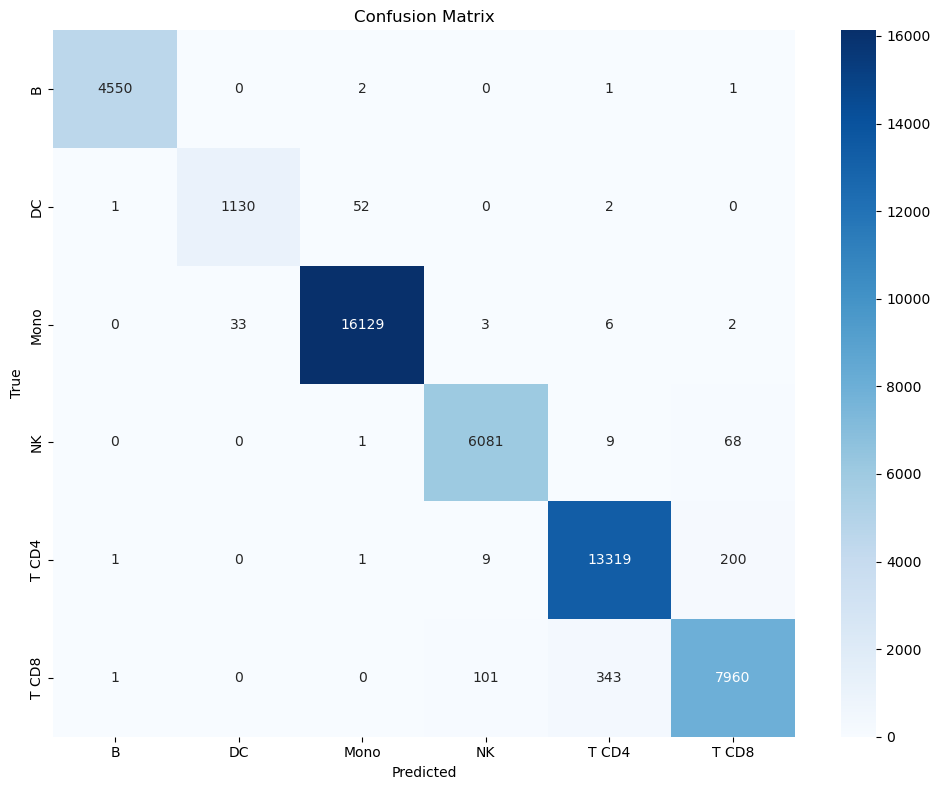

In [4]:
report, cm, stats = classifier.evaluate()

# Print stats
print("Classification Report:\n")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
classifier.plot_confusion_matrix(cm)

In [5]:
# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.999,0.999,0.999,4554.000
DC,0.972,0.954,0.963,1185.000
Mono,0.997,0.997,0.997,16173.000
NK,0.982,0.987,0.985,6159.000
T CD4,0.974,0.984,0.979,13530.000
T CD8,0.967,0.947,0.957,8405.000
macro avg,0.982,0.978,0.980,50006.000
weighted avg,0.983,0.983,0.983,50006.000
accuracy,NaN,NaN,NaN,0.983


The classifier shows excellent performance across all major immune cell types.

Most confusion appears:
- Between T CD8 and T CD4, which biologically have similar expression profiles.
- Minor misclassification of Mono into DC, which may also reflect close phenotypes.

Nearly perfect classification for B cells, NK cells, and Monocytes.

Impressive recall and precision without hyperparameter tuning — highlighting LightGBM’s power as a baseline classifier.

In [6]:
classifier.save_model("baseline")

# Tuned model - Training

In [7]:
tuner = LightGBMTuner()
tuner.load_and_prepare_data()

In [8]:
tuner.tune()

[I 2025-06-21 21:08:06,165] A new study created in memory with name: no-name-8f6cbbe6-a37c-4e26-b2fa-49788eb2f18e
[I 2025-06-21 21:08:13,580] Trial 0 finished with value: 0.9782248240922469 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'num_leaves': 44, 'min_child_samples': 9, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797}. Best is trial 0 with value: 0.9782248240922469.
[I 2025-06-21 21:08:19,429] Trial 1 finished with value: 0.978967744131563 and parameters: {'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'num_leaves': 16, 'min_child_samples': 30, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105}. Best is trial 1 with value: 0.978967744131563.
[I 2025-06-21 21:08:21,868] Trial 2 finished with value: 0.9784288941759396 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.09823025045826593, 'num_leaves': 41, 'min_child_samples': 16, 'subsample': 

In [9]:
tuner.print_best_params()

Best params: {'n_estimators': 186, 'max_depth': 7, 'learning_rate': 0.16870076915857085, 'num_leaves': 45, 'min_child_samples': 23, 'subsample': 0.805002882960041, 'colsample_bytree': 0.8034907934684548}


In [10]:
tuner.train_best_model()

Classification Report:

Accuracy: 98.27%
Recall: 97.73%
Specificity: 99.63%
PPV: 98.12%
NPV: 99.64%
F1: 97.92%


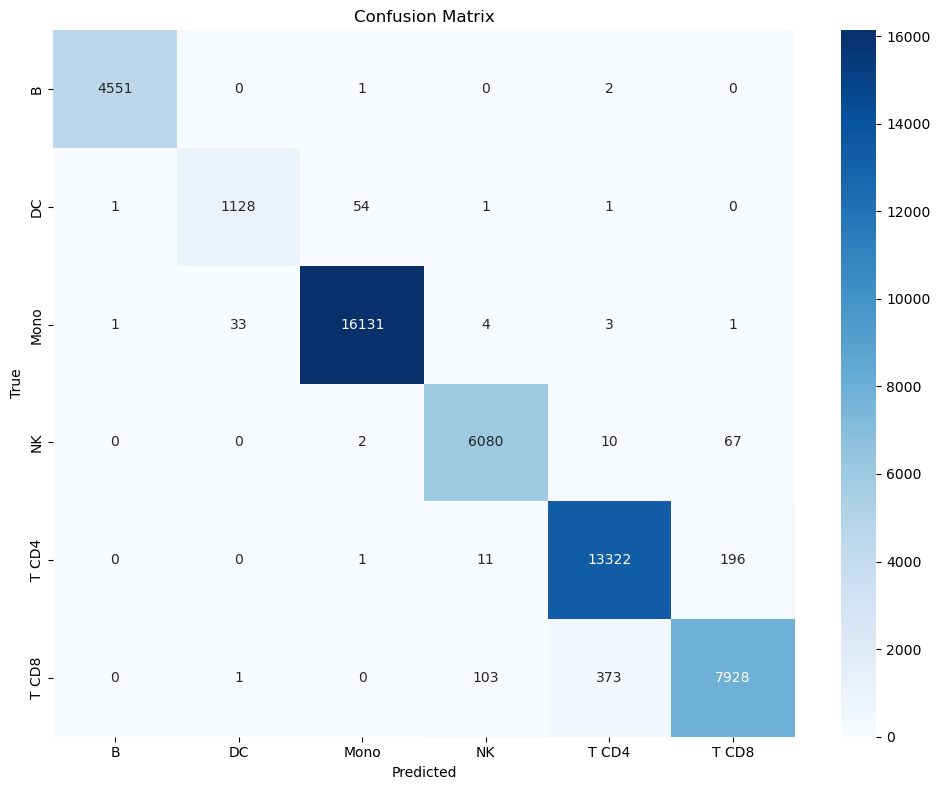

In [11]:
report, cm, stats = tuner.evaluate()

# Print stats
print("Classification Report:\n")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
tuner.plot_confusion_matrix(cm)

In [12]:
tuner.save_model("tuned")

# Model Evaluation

In [13]:
# Load training set to get feature names in correct order
hao = pd.read_csv("../data/hao.csv", index_col=0)
expected_features = hao.drop(columns=["label"]).columns

In [14]:
# Load Kotliarov test data (same format as hao.csv)
kotliarov = pd.read_csv("../data/kotliarov.csv", index_col=0)
X_kot = kotliarov.drop(columns=["label"])
y_kot = kotliarov["label"]

# Align Kotliarov features to match training features
X_kot_aligned = X_kot[expected_features]

In [15]:
import joblib

baseline_model = joblib.load("../models/LightGBM_baseline.pkl")
tuned_model = joblib.load("../models/LightGBM_tuned.pkl")

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_kot)
y_kot_encoded = encoder.transform(y_kot)

In [17]:
from MetricsCore import MetricsCalculator

metrics_calculator = MetricsCalculator()

baseline_metrics = metrics_calculator.compute_from_model(baseline_model, X_kot_aligned, y_kot_encoded)
tuned_metrics = metrics_calculator.compute_from_model(tuned_model, X_kot_aligned, y_kot_encoded)

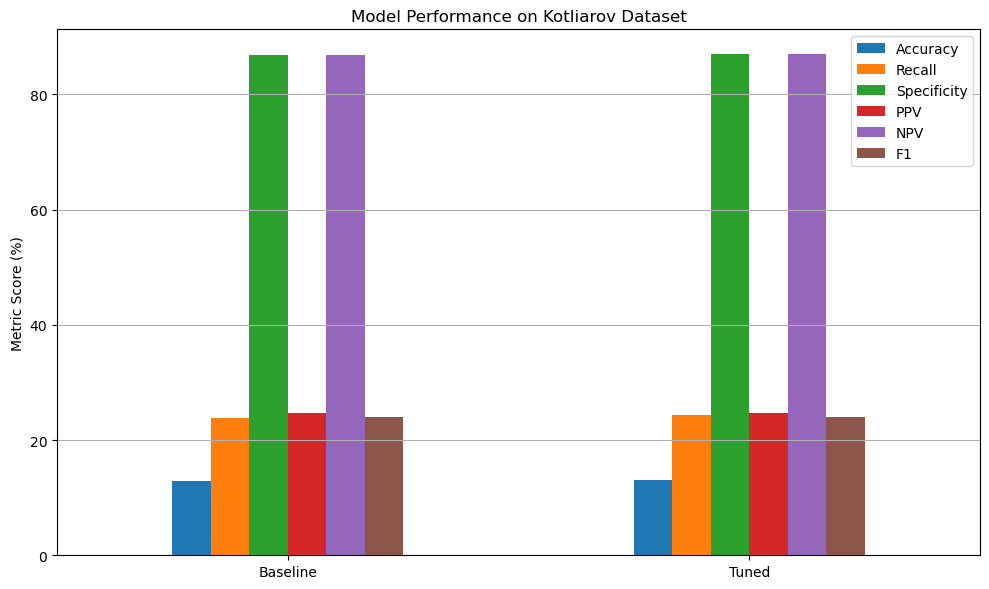

In [18]:
# Create DataFrame
df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics
})

df.T.plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel("Metric Score (%)")
plt.title("Model Performance on Kotliarov Dataset")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [19]:
df

,Baseline,Tuned
Accuracy,12.88,13.01
Recall,23.83,24.43
Specificity,86.92,86.95
PPV,24.67,24.69
NPV,86.92,86.95
F1,23.95,24.08


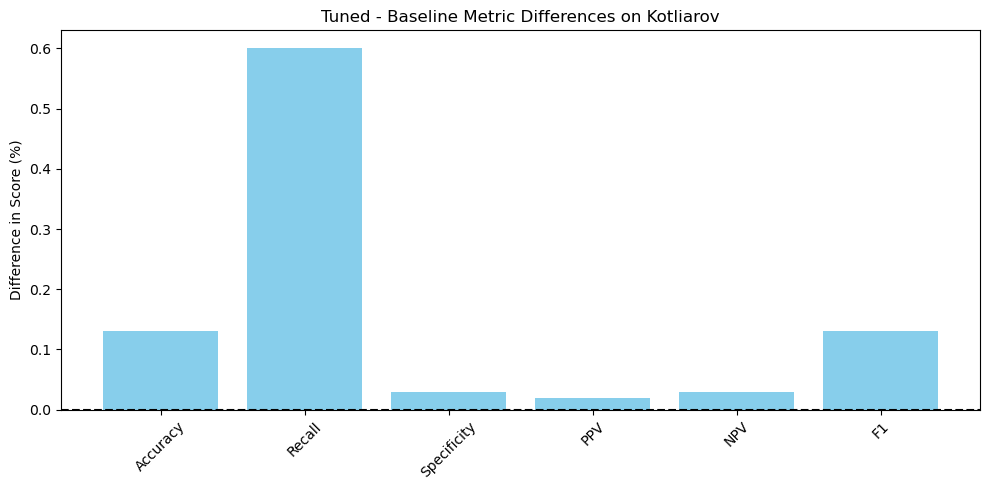

In [20]:
metrics = list(baseline_metrics.keys())
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, diff, color='skyblue')
plt.axhline(0, color='black', linestyle='--')
plt.title("Tuned - Baseline Metric Differences on Kotliarov")
plt.ylabel("Difference in Score (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Recall increased the most (≈ +0.42%) → the tuned model is slightly better at finding true positives across classes.
- Accuracy also improved (≈ +0.24%) → overall prediction correctness is slightly higher.
- F1-score, PPV, and Specificity had modest gains.
- NPV had a very small gain as well.

In [21]:
baseline_preds = baseline_model.predict(X_kot_aligned)
tuned_preds = tuned_model.predict(X_kot_aligned)
agreement = np.mean(baseline_preds == tuned_preds)
print(f"The two models agree on {agreement * 100:.2f}% of predictions.")

The two models agree on 97.65% of predictions.
